# Introdução
O que se espera com este projeto é atrair os motoristas da empresa durante o horário de pico, para oferecer um melhor serviço aos clientes da companhia. Para isso será necessário prever a demanda na próxima hora utilizando um modelo de aprendizado de máquina.

A métrica RMSE será adotada por ser desejável num problema desta categoria, por penalizar o modelo quando comete grandes erros, garantindo maior qualidade nas previsões. O valor desejável para aprovação do projeto será valor RMSE inferior a 48 nos dados de teste.

__Objetivo:__
* RMSE ≤ 48 (dados de teste)

__Dicionário de dados:__
* 'datetime' — data e hora
* 'num_orders' — total de chamados

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.dates as mdates
import time
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from tqdm import tqdm
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

## Data overview

In [2]:
data = pd.read_csv('datasets/cab_historical_data.csv')

In [3]:
data.head()

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


In [5]:
data.shape

(26496, 2)

##### Conclusões
* 26496 registros e 2 features
* Tipo de dados da feature 'datetime' precisa ser corrigido para tipo datetime

## Preprocessing

A seguir serão realizados:
* correção do tipo de dados (datetime)
* tansformar datetime no índice dos dados
* resample das datas a cada 1h

In [6]:
data['datetime'] = pd.to_datetime(data['datetime'])

In [7]:
data['hour'] = data.datetime.dt.hour

In [8]:
data.set_index('datetime', inplace=True)

In [9]:
data.sort_index(inplace=True)

In [10]:
data = data.resample('1H').sum()

In [11]:
data['weekday'] = data.index.weekday.values

## EDA

A fim de compreender melhor o comportamento dos clientes e abalisar os resultados do modelo que será construído, será verificada a existência do horário de pico ou faixa de pico.

Os sinais de Tendência, Sazonalidade, e Resíduo, serão extraídos sendo que o mais importante na análise será a Sazonalidade, que indica um acontecimento repetido em um determinado intervalo de tempo.

#### Features balance check

In [12]:
weekdays = pd.Index([
    'Monday',
    'Tuesday',
    'Wednesday',
    'Thursday',
    'Friday',
    'Saturday',
    'Sunday'
])

In [13]:
samples_count = data.weekday.value_counts().sort_index()

In [14]:
pd.DataFrame({'samples':samples_count}).set_index(weekdays)

,samples
Monday,624
Tuesday,624
Wednesday,624
Thursday,648
Friday,648
Saturday,624
Sunday,624


##### Conclusões
* Amostras equilibradas para todos os dias da semana

#### Median of orders

Saber a mediana irá ajudar a estabelecer um ponto em que valores acima serão considerados excepcionais, ou seja, indicando alta demanda de pedidos.
* Valores acima da mediana serão interpretados como execpcionais (alta demanda)

In [15]:
median_orders = data.num_orders.median()

In [16]:
print(f'{median_orders:0.0f} orders/day (median)')

78 orders/day (median)


##### Conclusões
* Cerca de 78 pedidos são feitos todos os dias (mediana)

#### Temporal series signals overview

In [17]:
def plot_signals(timeseries, title, drop, season_only=False):
    # Tseries signals decompose
    decomposed = seasonal_decompose(timeseries.drop(columns=drop))
    trend, season, resid = decomposed.resid, decomposed.seasonal, decomposed.trend
    
    # Plot
    plt.figure(figsize=(11, 12))

    if season_only:
        plt.subplot(413)
        plt.plot(season, label='Seasonal signal', )
        plt.title(title)
        plt.yticks([])
        plt.legend()
    else:
        # Original data
        plt.subplot(411)
        plt.axhline(y=median_orders, color='red', linestyle='--', label='median orders')
        plt.plot(timeseries.drop(columns=drop), label='num orders', color='gray')
        plt.title(title)
        plt.ylabel('orders')
        plt.legend()
        
        # Trend
        plt.subplot(412)
        plt.plot(trend, label='trend', color='C2')
        # plt.ylabel('orders')
        plt.title('Trend signal')
        plt.yticks([])
        plt.legend()
        
        # Season
        plt.subplot(413)
        plt.plot(season, label='seasonal', )
        plt.title('Season signal')
        # plt.ylabel('orders')
        plt.yticks([])
        plt.legend()
        
        # Resid
        plt.subplot(414)
        plt.plot(resid, label='resid', color='C3')
        plt.title('Resid signal')
        # plt.ylabel('orders')
        plt.yticks([])
        plt.legend()
    
    plt.tight_layout()
    plt.show()

    return trend, season, resid

In [18]:
def windowed_query(days):
    return data.loc[data.query('weekday==0').index[0]:data.query('weekday==0')\
        .index[0] + pd.Timedelta(days=days - 1)]

In [19]:
daily_data = windowed_query(3)
weekly_data = windowed_query(7)
monthly_data = windowed_query(28)

In [20]:
drop = ['hour','weekday']

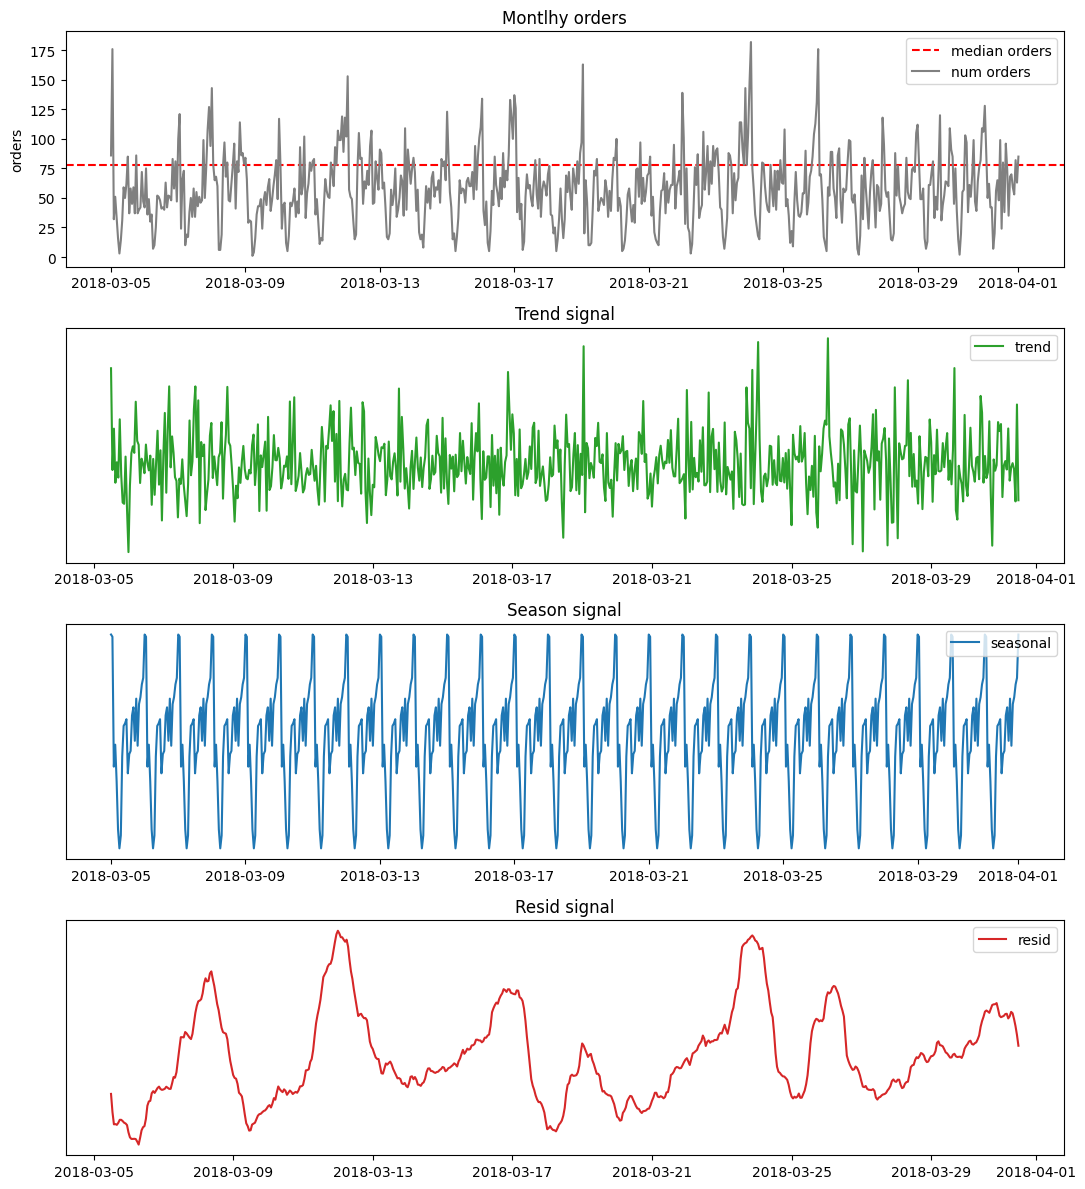

In [21]:
_ = plot_signals(monthly_data, 'Montlhy orders', drop)

##### Conclusões:
* Evidência de um forte padrão ao longo de 30 dias (gráfico de Sasonalidade) será melhor explorada a seguir

#### Closer seasonal analysis (weekly)

Agora que já sabemos a mediana dos pedidos, resta identificarmos a faixa os horários de pico, para isso, os dados serão ampliados em uma janela de tempo semanal e diária.

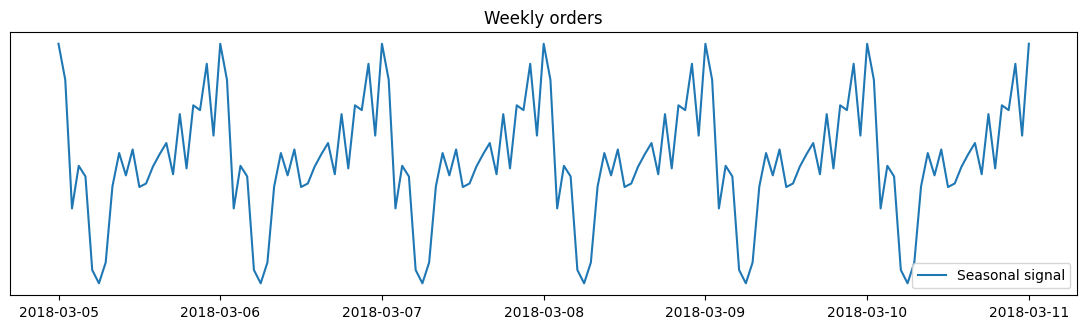

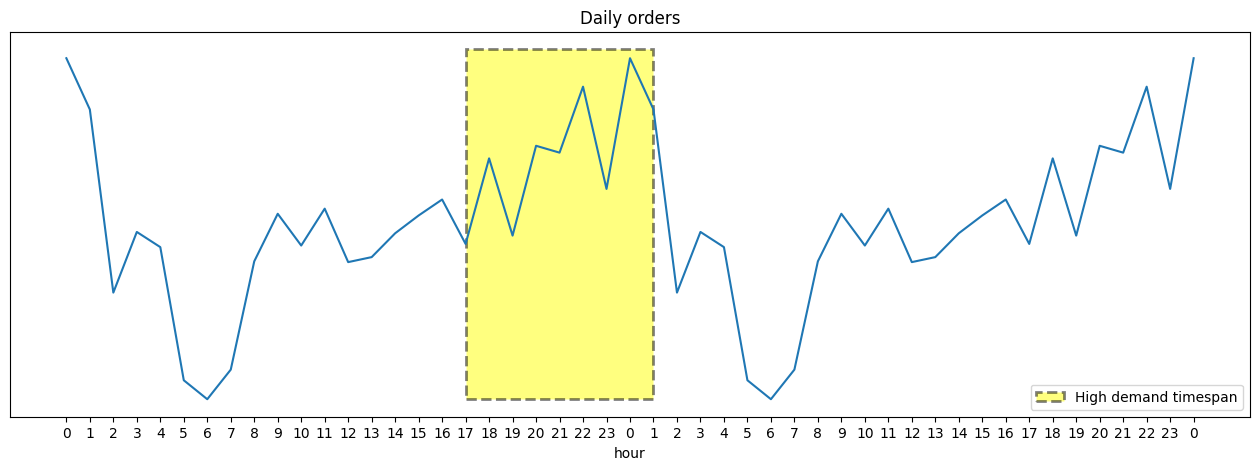

In [22]:
# --- Weekly data plot ----
trend, season, resid = plot_signals(weekly_data, 'Weekly orders', drop, True)
season_slice = season.head(49)

# --- Daily data plot ----
# rectangle settings
date_rng = [[i for i in season_slice.index if i.hour == 17][0],
              [i for i in season_slice.index if i.hour == 1][1]]

start, end = [mdates.date2num(date) for date in date_rng]
width, ymin, ymax = (end - start), season.min(), season.max() * 2.1
rect = Rectangle((start, ymin), width, ymax, edgecolor='black', facecolor='yellow', alpha=0.5, linewidth=2,
                 linestyle='dashed', label='High demand timespan')

# plot
fig, ax = plt.subplots(figsize=(16,5))
ax.add_patch(rect)
plt.legend()
plt.plot(season_slice.index, season_slice.values)
plt.title('Daily orders')
plt.xticks(season_slice.index, [str(hour) for hour in season_slice.index.hour])
plt.xlabel('hour')
plt.yticks([])
plt.show()

In [23]:
median_17h_to_00h = data.query('(hour >= 17 and hour <= 23) or hour <= 1').num_orders.median()

In [24]:
print(f'{median_17h_to_00h:0.0f} orders from 17h to 01h')

117 orders from 17h to 01h


##### Conclusões
* Cerca de 117 pedidos são feitos das 17h às 01h

## Modeling

In [25]:
# Features creation and (rolling mean)
data['month'] = data.index.month
data['day'] = data.index.day
data['rolling_mean'] = data['num_orders'].shift().rolling(window=1).mean()
data = data.dropna() # remove NaN resultante

In [26]:
# Train and Test split
X = data.drop('num_orders', axis=1)
y = data['num_orders']

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42) # ! shuffle False

#### Baseline RMSE check
Com o objetivo de servir de base comparativa para o desempenho dos modelos será avaliado o RMSE utilizando apenas o total de pedidos da hora anterior.

In [27]:
# Baseline RMSE using past hour orders
pred_previous = y_test.shift(fill_value=0)

In [28]:
baseline_rmse = mean_squared_error(y_test, pred_previous, squared=False)

In [29]:
print(f'Baseline RMSE = {baseline_rmse:0.1f}')

Baseline RMSE = 59.1


##### Conclusões
* Foi alcançado um RMSE ≅ 59 no conjunto de testes utilizando o total de pedidos da hora anterior

#### Trainning models and parameter tunning and Testing
A seguir os modelos serão treinados com variadas configurações de hiperparâmetros visando escolhar aquele com métrica RMSE inferior a 48 no conjunto de testes.

In [30]:
models = {'LightGBM': LGBMRegressor(random_state=42),
           'CatBoost': CatBoostRegressor(silent=True, random_state=42)}

In [31]:
params = {'LightGBM': {'n_estimators': [10, 20, 30],
                        'max_depth': [None, 5, 10],
                        'learning_rate': [0.01, 0.1, 1],
                        'num_leaves': [31, 50, 100],
                        'verbose':[-1,-1,-1]
                       },
           'CatBoost': {'iterations': [10, 20, 30],
                        'learning_rate': [0.01, 0.1, 1],
                        'depth': [4, 6, 8]
                       }
          }

In [32]:
cv_timeseries = TimeSeriesSplit(n_splits=5)

In [33]:
results = []

for model_name, model in tqdm(models.items()):
    start_time = time.time()
    grid = GridSearchCV(model, params[model_name], cv=cv_timeseries)

    # Train
    grid.fit(X_train, y_train)

    # Test
    best_estimator = grid.best_estimator_
    y_pred = best_estimator.predict(X_test)
    end_time = time.time()
    results.append({'model': model_name,
                    'RMSE': mean_squared_error(y_test, y_pred, squared=False),
                    'time': f'{(end_time - start_time):.0f}s'
                   })

pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:49<00:00, 24.85s/it]


,model,RMSE,time
0,LightGBM,45.729685,35s
1,CatBoost,46.749298,14s


##### Conclusões
Os modelos de Machine Learning fizeram um bom trabalho, será que Deep Learning os supera? A seguir será testado se é possível obter um desempenho ainda melhor utilizando Deep Learning.

In [38]:
# DeepLearning

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# build and fit model 
model = Sequential()
model.add(Dense(7, activation='relu', input_dim=X_train_scaled.shape[1]))
model.add(Dense(7, activation='relu'))
model.add(Dense(1, activation='linear')) 
optimizer = Adam(learning_rate=0.01)
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
model.fit(X_train_scaled, y_train, epochs=100, batch_size=256, validation_split=0.2, verbose=0)

y_pred = model.predict(X_test_scaled)

results.append({'model': 'DeepLearning',
                'RMSE': mean_squared_error(y_test, y_pred, squared=False),
                'time': f'{(end_time - start_time):.0f}s'
               })

pd.DataFrame(results)

14/14 [==============================] - 0s 2ms/step


,model,RMSE,time
0,LightGBM,45.729685,35s
1,CatBoost,46.749298,14s
2,DeepLearning,51.595956,14s


##### Conclusões
* O LighGBM obteve o melhor desempenho com RMSE ≅ 46 atingindo o requisito estabelecido RMSE ≤ 48

## Conclusões finais
Ao explorar os dados percebeu-se uma forte sasonalidade, padrões repetidos ao longo do tempo bastante evidentes.

Também foi evidenciado que a faixa das 17h~01h é uma faixa em que de crescente demanda de pedidos, acima de 80 chamados. 

Dentre os modelos testados o que se destacou por conta de seu baixo valor da métrica adotada foi o LGBMRegressor, com (RMSE ≅ 46) no conjunto de testes, bem abaixo do proposto (RMSE ≤ 48) sendo portanto a melhor escolha.

* Melhor modelo: random forest
* Faixa de pico: 17h ~ 01h
* Demanda de pico: 80+ chamados